# 3D binary image analysis

This sample analyzes a 50x50x50 size image. 
In this example code, we use cross-sectional images for each layer. In other words, prepare 50x50x50 images.
The file is located in the 'data_for_3d_analysis/' directory. Name the file in the order of the sections.

## Read data file
First, read this 50x50x50 image and make a 50x50x50 black and white array.

In [9]:
# Loading required libraries
import imageio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
!pip install homcloud

  ERROR: Command errored out with exit status 1:
   command: 'c:\users\johna\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\johna\\AppData\\Local\\Temp\\pip-install-mu43j7jq\\homcloud_92151c6afb2246a8aa47433a377c1b5e\\setup.py'"'"'; __file__='"'"'C:\\Users\\johna\\AppData\\Local\\Temp\\pip-install-mu43j7jq\\homcloud_92151c6afb2246a8aa47433a377c1b5e\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\johna\AppData\Local\Temp\pip-wheel-xfa0vs58'
       cwd: C:\Users\johna\AppData\Local\Temp\pip-install-mu43j7jq\homcloud_92151c6afb2246a8aa47433a377c1b5e\
  Complete output (101 lines):
  running bdist_wheel
  running build
  running build_py
  package init file 'homcloud\__init__.py' not found 


  Running setup.py clean for homcloud
  Created wheel for forwardable: filename=forwardable-0.4.1-py3-none-any.whl size=6245 sha256=bae828dea44020be46b9920fcfcc8d7f64c4a0be925f6afadba336dcb55a39fe
  Stored in directory: c:\users\johna\appdata\local\pip\cache\wheels\5f\8b\11\f821f6afc313dcd2f6b6d4144ab33bd1fd47fc64a03dedef91
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18096 sha256=df23b68262ae99e4ce92e843c16ea18335628678a4e92be7060e299002270c67
  Stored in directory: c:\users\johna\appdata\local\pip\cache\wheels\fb\f7\29\5c31600b478c23a3793be7cea9889d5eccb1e7ef40fef5e34e
Successfully built forwardable hopcroftkarp
Failed to build homcloud
    Running setup.py install for homcloud: started
    Running setup.py install for homcloud: finished with status 'error'


In [5]:
image_0000 = imageio.imread("C:\Users\johna\Documents\samples\samples\data_for_3d_analysis\0000.png")
image_0000.shape, image_0000.dtype, np.max(image_0000), np.min(image_0000)

((50, 50), dtype('uint8'), 255, 0)

In [6]:
pict = np.stack([
    imageio.imread("C:\Users\johna\Documents\samples\samples\data_for_3d_analysis\{:04d}.png".format(n)) > 128
    for n in range(50) 
], axis=0)

Let's visualize this in 3D. by using the `plotly.graph_objects` and
`homcloud.plotly_3d` module.
See[API documentation](http://homcloud.dev/python-api/plotly_3d.html) for details. The VoxelData class is mainly used. 

In [7]:
import homcloud.plotly_3d as p3d
import plotly.graph_objects as go

ModuleNotFoundError: No module named 'homcloud'

In [8]:
fig = go.Figure(data=[p3d.Bitmap3d(pict)], layout=dict(scene=p3d.SimpleScene()))
fig.update_traces(opacity=0.5, selector=dict(type="mesh3d"))
fig.show()

NameError: name 'go' is not defined

## Calculation of persistence diagram
Calculate persistence diagram. Use `hc.PDList.from_bitmap_distance_function`.

In [6]:
import homcloud.interface as hc

In [7]:
pdlist = hc.PDList.from_bitmap_levelset(hc.distance_transform(pict, signed=True), save_to="binary-3d.pdgm")

You can also load the file as follows.

In [8]:
pdlist = hc.PDList("binary-3d.pdgm")

## Analysis of persistence diagram(0th) and its inverse analysis

Let's analyze the 0th-order persistence diagram.

First, plot a 0th-order persistence diagram.

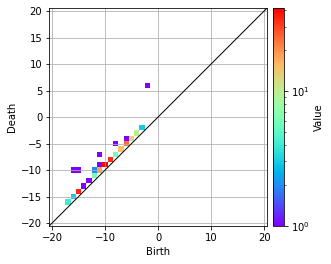

In [9]:
pd0 = pdlist.dth_diagram(0)
pd0.histogram((-20.5, 20.5), 41).plot(colorbar={"type": "log"})

Let's take a closer look at the two birth-death pairs, `(-16.0, -10.0), (-15.0, -10.0)`. Use a class called `BitmapPHTrees` for the 0th and 2nd order inverse analysis of voxel data(it cannot be used for the 1st order, so we used the `optimal_1_cycle` described above instead).
`BitmapPHTrees.for_bitmap_levelset` has an interface similar to `PDList.from_bitmap_levelset`, calculate information for back analysis.

The name PHTrees means that what is computed here is a tree structure.
`BitmapPHTrees.for_bitmap_levelset` simulateneously computes two forests for 
the information of 0th and (n-1)th PH of an n dimensional bitmap.

In [10]:
hc.BitmapPHTrees.for_bitmap_levelset(hc.distance_transform(pict, signed=True), 
                                     save_to="binary-3d-tree.pdgm")

PDList(path=binary-3d-tree.pdgm)

Load the data calculated as follows.

In [11]:
pdlist_with_tree = hc.PDList("binary-3d-tree.pdgm")

Let's use `bitmap_phtrees(0)` to retrieve the 0th PH's information.

In [12]:
phtree_0 = pdlist_with_tree.bitmap_phtrees(0)

Use `pair_nodes_in_rectangle` to retrieve information on the two birth-death pairs `(-16.0, -10.0), (-15.0, -10.0)`. This retrieves all birth-death pairs (with corresponding tree nodes)
within the specified range.

In [13]:
nodes_0 = phtree_0.pair_nodes_in_rectangle(-16, -15, -10, -10)
nodes_0

[BitmapPHTrees.Node(-15.0, -10.0), BitmapPHTrees.Node(-16.0, -10.0)]

The extracted data is an instance of the class called `BitmapPHTrees.Node`. Next, let's visualize this information.

In [ ]:
fig = go.Figure(data=[
    n.to_plotly3d() for n in nodes_0
] + [
    p3d.Bitmap3d(pict, color="black", name="bitmap")
], layout=dict(scene=p3d.SimpleScene()))
fig.update_traces(opacity=0.5, selector=dict(type="mesh3d"))
fig.update_traces(opacity=0.2, selector=dict(name="bitmap"))
fig.show()

# Analysis of persistence diagram(1st) and its inverse analysis

Let's analyze the first-order persistence diagram.

First, plot a first-order persistence diagram.

In [ ]:
pd1 = pdlist.dth_diagram(1)
pd1.histogram((-15.5, 10.5), 26).plot(colorbar={"type": "log"})

There seems to be two birth-death pairs at (-4, 4). Let's check this.

In [ ]:
pairs = pd1.pairs_in_rectangle(-4, -4, 4, 4)
pairs

Let's take a look at what the two pairs represent. Because you are looking at the first-order persistence homology, you should be looking at some kind of ring structure. Let's calculate it.

Here you use the optimal cycle. In point cloud analysis, we used optimal volume and volume-optimal cycle. It's similar (slightly different) Calculate with `Pair.optimal_1_cycle`.

In [ ]:
optimal_1_cycles = [pair.optimal_1_cycle() for pair in pairs]
optimal_1_cycles[0].to_plotly3d

Let's visualize this first. Displays the original voxel data superimposed.

In [ ]:
fig = go.Figure(data=[
    cycle.to_plotly3d() for cycle in optimal_1_cycles
] + [
    p3d.Bitmap3d(pict, color="black", name="bitmap"),
], layout=dict(scene=p3d.SimpleScene()))
fig.update_traces(opacity=0.1, selector=dict(name="bitmap"))
fig.show()

Next, let's see what path this ring structure is taking. Use `Optimal1CycleForBitmap.path`. You can get the coordinates of pixel at the passing point.

In [ ]:
optimal_1_cycles[0].path()

##  Analysis of persistence diagram (secondary) and its inverse analysis
Finally, let's analyze the second-order persistence diagram.

Plot a second-order persistence diagram.

In [ ]:
pd2 = pdlist.dth_diagram(2)
pd2.histogram((-20.5, 20.5), 41).plot(colorbar={"type": "log"})

Examine the birth-death pair called `(4, 6)`. For inverse analysis, use `bitmap_phtrees(2)`. 

Let's look at the birth-death pair called (4, 6). First, extract all birth-death pairs (4, 6)(nodes of the tree corresponding to) with `pair_nodes_in_rectangle`.

In [ ]:
phtree_2 = pdlist_with_tree.bitmap_phtrees(2)
nodes_2 = phtree_2.pair_nodes_in_rectangle(4, 4, 6, 6)
nodes_2

Two the following is the result of visualization.　You can see that the deeper part of the hollow area corresponds to this birth-death pair.

In [ ]:
fig = go.Figure(data=[
    n.to_plotly3d() for n in nodes_2
] + [
    p3d.Bitmap3d(pict, color="black", name="bitmap")
], layout=dict(scene=p3d.SimpleScene()))
fig.update_traces(opacity=0.2, selector=dict(name="bitmap"))
fig.show()